# Rolling Planning mit Flow Time

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import src.utils.gen_jobs as gen_jobs
import src.utils.rolling_scheduling as rolling_schedule

import time
import pandas as pd
pd.set_option('display.max_rows', 26)

In [2]:
import src.models.lp.flowtime_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

In [3]:
max_time = 60*2 # 2min

## Generierung des Datensatzes für 10 Tage (Ankunft)

In [4]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 10, u_b_mmax= 0.92, shuffle = True)
df_jobs_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.09
2,Job_002,103.88
3,Job_003,145.10
4,Job_004,181.06
...,...,...
226,Job_226,14272.06
227,Job_227,14315.57
228,Job_228,14364.35
229,Job_229,14380.89


In [5]:
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
2305,Job_230,5,M9,72
2306,Job_230,6,M0,47
2307,Job_230,7,M6,65
2308,Job_230,8,M4,6


## Params

In [6]:
# fix
day_length = 1440
horizon_days = 3

In [7]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [8]:
day_numb = 0

In [9]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [10]:
# I)
df_jssp_curr, df_times_curr = rolling_schedule.filter_jobs_by_arrival_window(df_jobs_arrivals, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
635,Job_063,5,M8,52
636,Job_063,6,M7,85
637,Job_063,7,M3,98
638,Job_063,8,M9,22


In [11]:
df_times_curr 

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.09
2,Job_002,103.88
3,Job_003,145.10
4,Job_004,181.06
...,...,...
59,Job_059,4151.66
60,Job_060,4159.86
61,Job_061,4162.65
62,Job_062,4168.40


### Scheduling

In [12]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_jssp_flowtime(df_jssp_curr, df_times_curr, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.10)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 38000

Solver-Informationen:
  Summe Flow Times        : 214342.21
  Solver-Status           : Optimal
  Anzahl Variablen        : 20864
  Anzahl Constraints      : 40960

Scheduling-Dauer: 2 Minuten und 0.96 Sekunden.


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29.0,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78.0,107.00,107.00
2,Job_001,0,83.09,M0,83.09,43.0,43.00,126.09
3,Job_000,2,0.00,M2,107.00,9.0,116.00,116.00
4,Job_002,0,103.88,M1,107.00,91.0,94.12,198.00
...,...,...,...,...,...,...,...,...
635,Job_063,6,4309.16,M7,10411.00,85.0,6186.84,10496.00
636,Job_061,9,4162.65,M7,10496.00,45.0,6378.35,10541.00
637,Job_063,7,4309.16,M3,10496.00,98.0,6284.84,10594.00
638,Job_063,8,4309.16,M9,10594.00,22.0,6306.84,10616.00


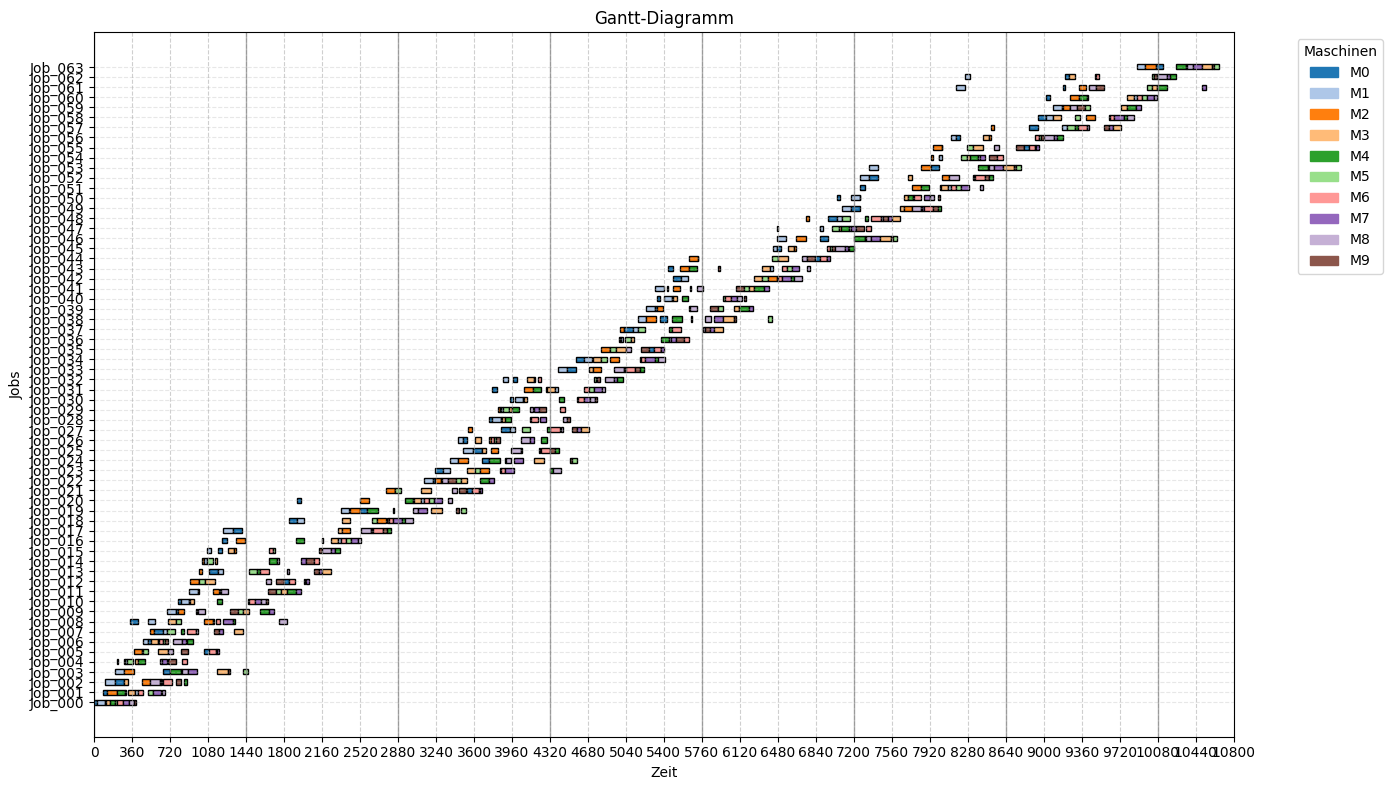

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

### Simulation

In [14]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:19:52] Job_000 finished on M0 (after 19 minutes 53 seconds)
[00:29:00] Job_000 started on M1
[01:23:05] Job_001 started on M0
[02:05:15] Job_001 finished on M0 (after 42 minutes 10 seconds)
[02:06:05] Job_001 started on M2
[03:16:10] Job_000 finished on M1 (after 167 minutes 10 seconds)
[03:16:10] Job_002 started on M1
[03:26:10] Job_001 finished on M2 (after 80 minutes 05 seconds)
[03:26:10] Job_000 started on M2
[03:36:05] Job_001 started on M4
[03:37:51] Job_000 finished on M2 (after 11 minutes 41 seconds)
[03:37:51] Job_004 started on M2
[03:37:51] Job_000 started on M3
[03:51:04] Job_004 finished on M2 (after 13 minutes 13 seconds)
[04:05:15] Job_000 finished on M3 (after 27 minutes 24 seconds)
[04:17:26] Job_002 finished on M1 (after 61 minutes 17 seconds)
[04:17:26] Job_003 started on M1
[04:17:26] Job_002 started on M0
[04:29:22] Job_001 finished on M4 (after 53 minutes 17 seconds)
[04:29:22] Job_000 started on M4
[04:51:05] Job_001 started 

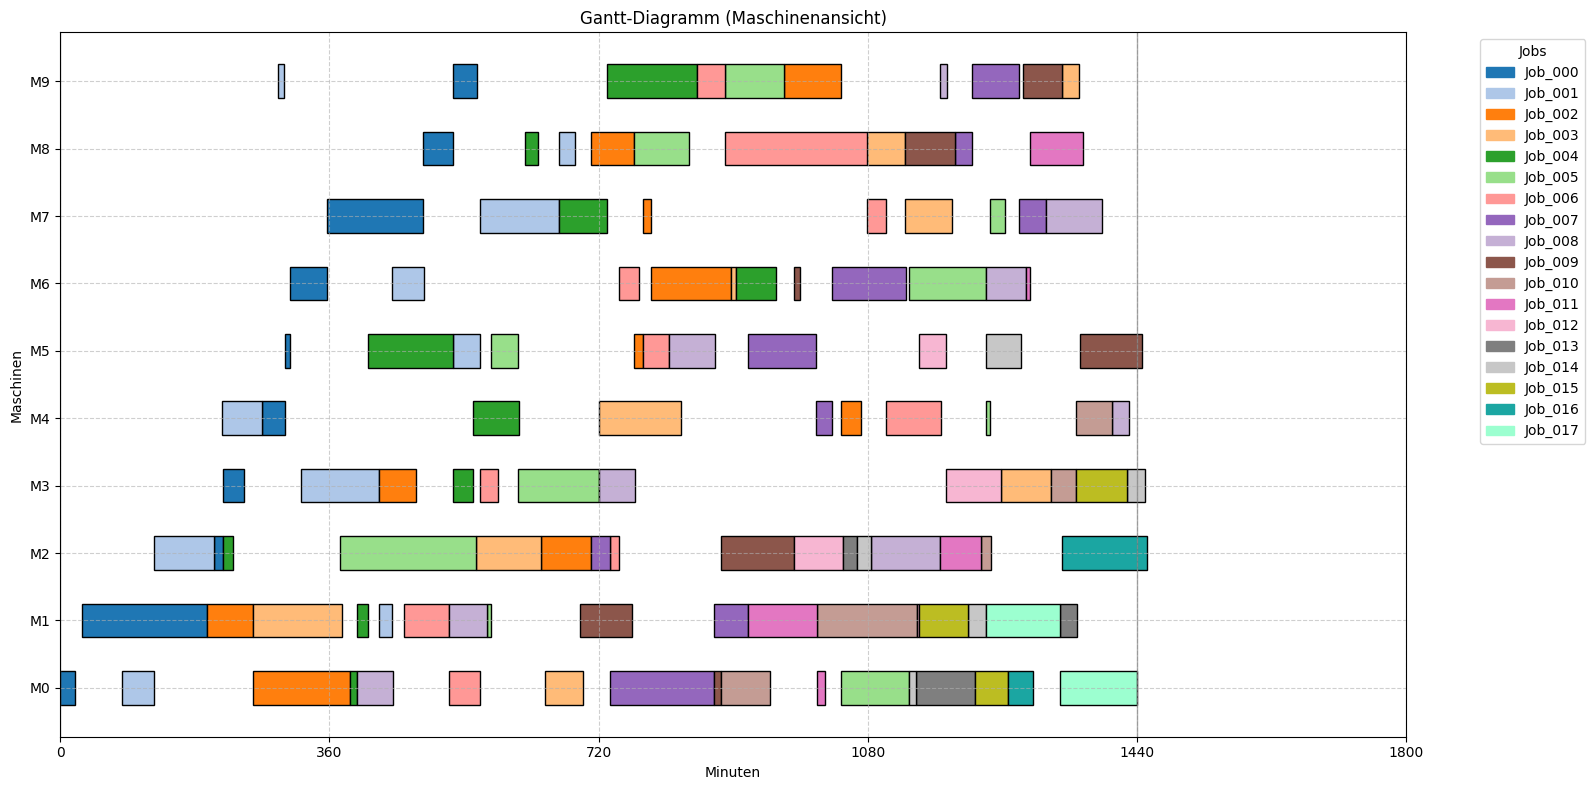

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_007,9,322.49,M3,1327.0,79.0
1,Job_015,3,567.55,M2,1327.0,13.0
2,Job_003,9,145.10,M5,1411.0,43.0
3,Job_009,7,419.90,M3,1411.0,52.0
4,Job_010,5,463.55,M5,1454.0,11.0
...,...,...,...,...,...,...
512,Job_063,6,4309.16,M7,10411.0,85.0
513,Job_061,9,4162.65,M7,10496.0,45.0
514,Job_063,7,4309.16,M3,10496.0,98.0
515,Job_063,8,4309.16,M9,10594.0,22.0


#### Export

In [20]:
export_data_path = get_path("data", "lp_flowtime")

In [22]:
df_jssp.to_csv(export_data_path / "02_flowtime_all_jssp.csv", index = False)
df_jobs_arrivals.to_csv(export_data_path / "02_flowtime_all_times.csv", index = False)

In [24]:
df_plan.to_csv(export_data_path / "02_flowtime_init_plan.csv", index = False)
df_execution.to_csv(export_data_path / "02_flowtime_execution.csv", index = False)
df_undone.to_csv(export_data_path / "02_flowtime_init_undone.csv", index = False)